In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scienceplots
%matplotlib inline
from seaborn import displot, histplot, scatterplot, relplot
plt.style.use(['seaborn-v0_8-paper'])
from tqdm import tqdm
from shapely.geometry import LineString
from conflict import ConflictLyft

with open('./lyft_avhv_conflict.pkl', 'rb') as file:
    lyft_avhv_conflict_list = pickle.load(file)

with open('./lyft_hvhv_conflict.pkl', 'rb') as file:
    lyft_hvhv_conflict_list = pickle.load(file)

lyft_conflict_list = lyft_avhv_conflict_list + lyft_hvhv_conflict_list

# convert the type to latest conflict object
conflict_list = list()
for c_index, c in enumerate(lyft_conflict_list):
    # print(c_index)
    conflict_list.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
    ))
assert len(conflict_list) == len(lyft_conflict_list)

C:\Users\LocalAdmin\Documents\GitHub\lyft_intersection\extract_intersections\conflict.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  follower_trajectory_length / self.follower_beforeConflict_speeds[follower_index] - \
C:\Users\LocalAdmin\Documents\GitHub\lyft_intersection\extract_intersections\conflict.py:173: RuntimeWarning: divide by zero encountered in scalar divide
  leader_trajectory_length / self.leader_beforeConflict_speeds[leader_index]
C:\Users\LocalAdmin\Documents\GitHub\lyft_intersection\extract_intersections\conflict.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  TTCs.append(follower_trajectory_length / (self.follower_beforeConflict_speeds[follower_index]))


In [5]:
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "TTC",
    "leader_speed",
    "follower_speed",
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for conflict in conflict_list:
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    PET = conflict.PET

    if conflict.two_vehicles_co_exist:
        states = conflict.states_before_conflictPoint[:, [1,6,7]]
        states = states[~np.isnan(states).any(axis=1)]
        
        for state in states:
            conflict_rows_in_df.append([
                    conflict_type,
                    leader_type+"-"+follower_type,
                    PET,
                    state[0],
                    state[1],
                    state[2],
                ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info(), conflict_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35272 entries, 0 to 35271
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Conflict type   35272 non-null  object 
 1   Vehicle order   35272 non-null  object 
 2   PET             35272 non-null  float64
 3   TTC             35272 non-null  float64
 4   leader_speed    35272 non-null  float64
 5   follower_speed  35272 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.9+ MB


(None, (35272, 6))

In [6]:
# Post-process: remove TTC greater than 10s
TTC_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["TTC"] <= TTC_THRESHOLD]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18248 entries, 0 to 35258
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Conflict type   18248 non-null  object 
 1   Vehicle order   18248 non-null  object 
 2   PET             18248 non-null  float64
 3   TTC             18248 non-null  float64
 4   leader_speed    18248 non-null  float64
 5   follower_speed  18248 non-null  float64
dtypes: float64(4), object(2)
memory usage: 997.9+ KB


<Figure size 300x300 with 0 Axes>

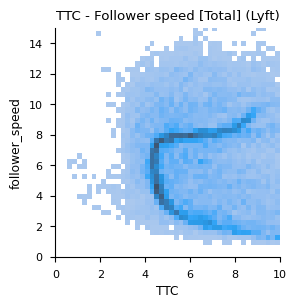

In [15]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="TTC", 
    y="follower_speed",
    height=FIGURE_HEIGHT,
    aspect=1.0,
)

plt.xlim([0, TTC_THRESHOLD])
plt.ylim([0, 15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC - Follower speed [{conflictType}] (Lyft)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 300x300 with 0 Axes>

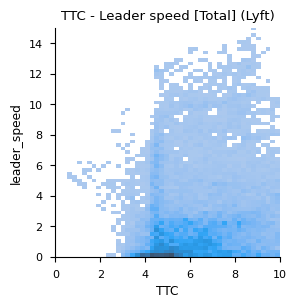

In [16]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="TTC", 
    y="leader_speed",
    height=FIGURE_HEIGHT,
    aspect=1.0,
)

plt.xlim([0, TTC_THRESHOLD])
plt.ylim([0, 15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC - Leader speed [{conflictType}] (Lyft)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()